
# 12. Self-calibrated CS-pMR image reconstruction from undersampled non-Cartesian data

In this tutorial we will reconstruct an MRI image from radial undersampled kspace measurements. Let us denote $\Omega$ the undersampling mask, the under-sampled Fourier transform now reads $F_{\Omega}$.

We use the toy datasets available in pysap, more specifically a 2D brain slice and under-sampled Cartesian acquisition over 32 channels.
We compare zero-order image reconstruction with **self-calibrated** multi-coil Compressed sensing reconstructions (analysis vs synthesis formulation) using the FISTA algorithm for the synthesis formulation and the Condat-Vu algorithm for the analysis formulation. The multicoil data $(y_\ell)_\ell$ is collected across multiple, say $L$, channels. The sensitivity maps $(S_\ell)_\ell$ are automically calibrated from the central portion of k-space (e.g. 5%) for all channels $\ell=1, \ldots, L$.

We remind that the synthesis formulation of the non-Cartesian CS-PMRI problem reads (minimization in the sparsifying domain):

$$
\widehat{z} = \text{arg}\,\min_{z\in C^n_\Psi} \frac{1}{2} \sum_{\ell=1}^L\|y_\ell - F_\Omega  S_\ell \Psi^*z \|_2^2 + \lambda \|z\|_1
$$

and the image solution is given by $\widehat{x} = \Psi^*\widehat{z}$. For an orthonormal wavelet transform,
we have $n_\Psi=n$ while for a frame we may have $n_\Psi > n$.

while the analysis formulation consists in minimizing the following cost function (min. in the image domain):

$$
\widehat{x} = \text{arg}\,\min_{x\in C^n} \frac{1}{2} \sum_{\ell=1}^L \|y_\ell - F_\Omega  S_\ell x\|_2^2 + \lambda \|\Psi x\|_1 \,.
$$

- Author: Chaithya G R & Philippe Ciuciu
- Date: 01/06/2021
- Target: ATSI MSc students, Paris-Saclay University

In [1]:
#DISPLAY BRAIN PHANTOM
%matplotlib inline

# Package import
from mri.operators import NonCartesianFFT, WaveletN, WaveletUD2
from mri.operators.utils import convert_locations_to_mask, \
    gridded_inverse_fourier_transform_nd
from mri.reconstructors import SelfCalibrationReconstructor
from mri.reconstructors.utils.extract_sensitivity_maps import get_Smaps

import pysap
from pysap.data import get_sample_data

# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np
import matplotlib.pyplot as plt

## Loading input data

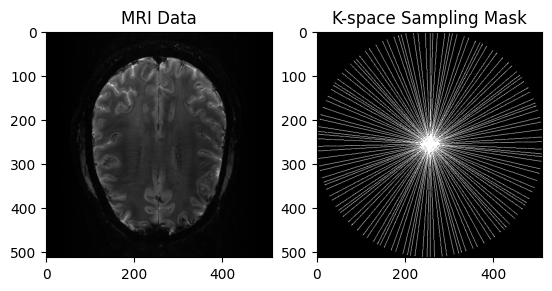

In [23]:
# Loading input data
cartesian_ref_image = get_sample_data('2d-pmri')
#image = pysap.Image(data=np.sqrt(np.sum(cartesian_ref_image.data**2, axis=0)))
image = np.linalg.norm(cartesian_ref_image, axis=0)

# Obtain MRI non-Cartesian radial mask
radial_mask = get_sample_data("mri-radial-samples")
kspace_loc = radial_mask.data
mask = pysap.Image(data=convert_locations_to_mask(kspace_loc, image.shape))

plt.subplot(1, 2, 1)
plt.imshow(np.abs(image), cmap='gray')
plt.title("MRI Data")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("K-space Sampling Mask")
plt.show()

## Generate the kspace

From the 2D brain slice and the acquisition mask, we retrospectively undersample the k-space using a non cartesian acquisition mask.
We then grid the kspace to get the gridded solution as a baseline.

In [24]:
# Get the kspace observation values for the kspace locations
fourier_op = NonCartesianFFT(
    samples=kspace_loc,
    shape=image.shape,
    n_coils=cartesian_ref_image.shape[0],
    implementation='finufft' # Use gpuNUFFT for speed
)

kspace_obs = fourier_op.op(cartesian_ref_image.data)

Gridded solution

The Base SSIM is : 0.6179875044084614


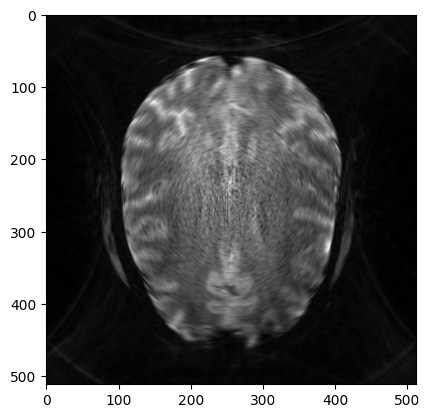

In [25]:
# Gridded solution
grid_space = np.linspace(-0.5, 0.5, num=image.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)
grid_soln = np.asarray([
    gridded_inverse_fourier_transform_nd(kspace_loc, kspace_obs_ch,
                                         tuple(grid2D), 'linear')
    for kspace_obs_ch in kspace_obs
])
image_rec0 = pysap.Image(data=np.sqrt(np.sum(np.abs(grid_soln)**2, axis=0)))

plt.imshow(image_rec0, cmap='gray')
base_ssim = ssim(image_rec0, image)
print('The Base SSIM is : {}'.format(base_ssim))

## Estimate Sensitivity maps (Smaps)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  32 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.3s finished


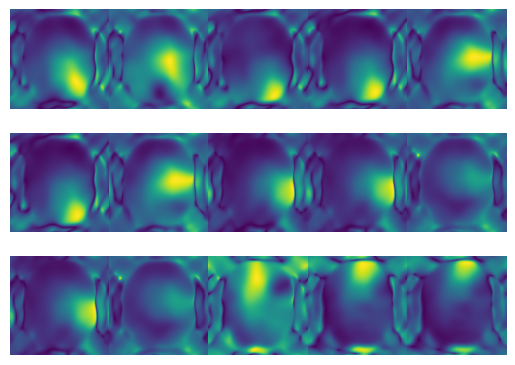

In [26]:
# Obtain SMaps
Smaps, SOS = get_Smaps(
    k_space=kspace_obs.astype(np.complex64),
    img_shape=fourier_op.shape,
    samples=kspace_loc,
    thresh=(0.01, 0.01),    # The cutoff threshold in each kspace direction
                            # between 0 and kspace_max (0.5)
    min_samples=kspace_loc.min(axis=0),
    max_samples=kspace_loc.max(axis=0),
    mode='gridding',
    method='linear',
    n_cpu=-1,
)

h=3;w=5;
f, axs = plt.subplots(h,w)
for i in range(h):
    for j in range(w):
        axs[i, j].imshow(np.abs(Smaps[3 * i + j]))
        axs[i, j].axis('off')
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

In [14]:
#!pip install pynfft2

## Setup Fourier operators with SENSE

In [27]:
# Setup Fourier Operator with SENSE. This would initialize the
# fourier operators in the GPU.
# For this we need to specify the implementation as gpuNUFFT
# and also pass the Smaps calculated above
fourier_implementation = 'finufft'

fourier_op_sense = NonCartesianFFT(
    samples=kspace_loc,
    shape=image.shape,
    n_coils=cartesian_ref_image.shape[0],
    smaps=Smaps,
    implementation=fourier_implementation,
)

/volatile/home/pc174679/codes/venv/lib/python3.10/site-packages/mrinufft/_utils.py:94: UserWarning: Samples will be rescaled to [-pi, pi), assuming they were in [-0.5, 0.5)
  warnings.warn(


## FISTA optimization

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

In [28]:
# Setup the operators
linear_op = WaveletN(wavelet_name='sym8', nb_scale=4)
regularizer_op = SparseThreshold(Identity(), 1e-8, thresh_type="soft")

In [29]:
# Setup Reconstructor
reconstructor = SelfCalibrationReconstructor(
    fourier_op=fourier_op_sense,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

TypeError: Argument `data` does not have the correct dtype: complex128 was given, but complex64 was expected.

## Synthesis formulation: FISTA optimization

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

 - mu:  1e-08
 - lipschitz constant:  11.996995639801026
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7e82893c0bb0> - 4
 - max iterations:  100
 - image variable shape:  (512, 512)
 - alpha variable shape:  (291721,)
----------------------------------------
Starting optimization...


  0%|          | 0/100 [00:00<?, ?it/s]

 - final iteration number:  100
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  22.336278692000633  seconds
----------------------------------------


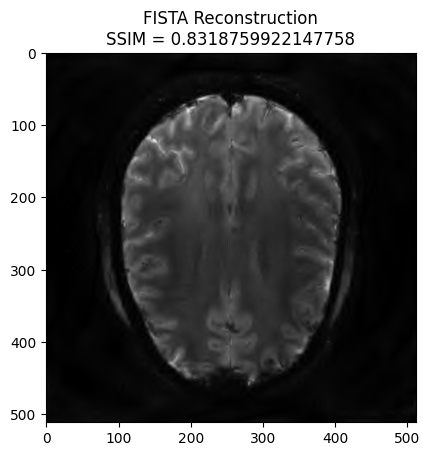

In [10]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=100,
)

image_rec = pysap.Image(data=x_final)
recon_ssim = ssim(image_rec, image)

plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('FISTA Reconstruction\nSSIM = {}'.format(recon_ssim))
plt.show()

## POGM reconstruction

 - mu:  1e-08
 - lipschitz constant:  11.996995639801026
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7e82893c0bb0> - 4
 - max iterations:  200
 - image variable shape:  (1, 512, 512)
----------------------------------------
Starting optimization...


  0%|          | 0/200 [00:00<?, ?it/s]

 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  46.64160440299747  seconds
----------------------------------------


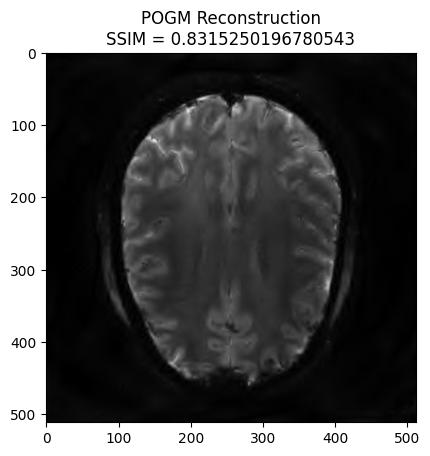

In [11]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='pogm',
    num_iterations=200,
)

image_rec = pysap.Image(data=np.abs(x_final))
recon_ssim = ssim(image_rec, image)

plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('POGM Reconstruction\nSSIM = {}'.format(recon_ssim))
plt.show()

## Analysis formulation: Condat-Vu reconstruction

In [12]:
#linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
linear_op = WaveletUD2(
    wavelet_id=24,
    nb_scale=4,
)
regularizer_op = SparseThreshold(Identity(), 1e-8, thresh_type="soft")

In [13]:
# Setup Reconstructor
reconstructor = SelfCalibrationReconstructor(
    fourier_op=fourier_op_sense,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)

Lipschitz constant is 11.99696626663208


 - mu:  1e-08
 - lipschitz constant:  11.99696626663208
 - tau:  0.15348748751641356
 - sigma:  0.5
 - rho:  1.0
 - std:  None
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletUD2 object at 0x7e82893de650> - 4
 - max iterations:  200
 - number of reweights:  0
 - primal variable shape:  (512, 512)
 - dual variable shape:  (2621440,)
----------------------------------------
Starting optimization...


  0%|          | 0/200 [00:00<?, ?it/s]

 - final iteration number:  200
 - final cost value:  1000000.0
 - converged:  False
Done.
Execution time:  475.7525305880008  seconds
----------------------------------------


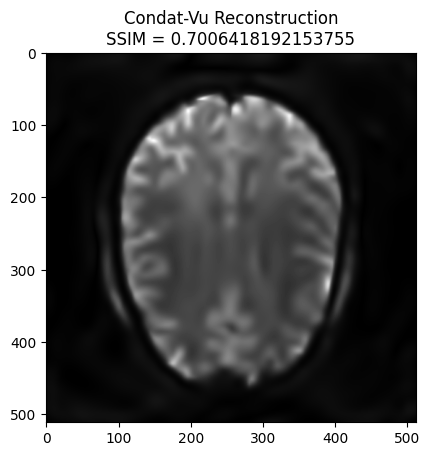

In [14]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='condatvu',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('Condat-Vu Reconstruction\nSSIM = {}'.format(recon_ssim))
plt.show()